In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-11-06 19:45:06.067652: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 19:45:06.930577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 128
dataset_take = 1000
learning_rate = 1.5e-3
batch_per_file_size = 8
node_embedding_size = 15
layers = [128, 64, 32, 36, 24]

dataset = LayoutDataset(
    batch_size, dataset_take, 
    train_sample_fraction=1.0,
    subset=None, build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-11-06 19:45:09.814801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 19:45:09.923323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 19:45:09.923572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

train layout:nlp:default 1000
train layout:nlp:random 1000
train layout:xla:random 3000
train layout:xla:default 3000
test all_filenames 10000
valid all_filenames 1000


In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    mask_max_len=dataset.n_config_nodes_upper_limit,
    batch_per_file_size=batch_per_file_size,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='pairwise_hinge',
    l1_multiplier=2e-8,
    n_siblings=dataset.n_siblings
)

In [4]:
mlp.train(dataset, None)

2023-11-06 19:48:30.637025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-06 19:48:30.681075: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f55963e8b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-06 19:48:30.681096: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-06 19:48:30.725089: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-06 19:48:30.981194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-06 19:48:31.194994: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.137658 lr 0.00007
iteration 1000 training loss 2.6765325 lr 0.00015
iteration 1500 training loss 2.7256873 lr 0.00022
iteration 2000 training loss 1.9848877 lr 0.00030
iteration 2500 training loss 1.7636325 lr 0.00037
iteration 3000 training loss 2.206547 lr 0.00045
iteration 3500 training loss 1.844537 lr 0.00052
iteration 4000 training loss 1.8799472 lr 0.00060
iteration 4500 training loss 2.9073596 lr 0.00067
iteration 5000 training loss 1.8202782 lr 0.00075
iteration 5500 training loss 1.890493 lr 0.00082
iteration 6000 training loss 1.5784329 lr 0.00090
iteration 6500 training loss 1.5438331 lr 0.00097
iteration 7000 training loss 1.7261629 lr 0.00105
iteration 7500 training loss 1.5374976 lr 0.00112
iteration 8000 training loss 1.758756 lr 0.00120
iteration 8500 training loss 1.4484636 lr 0.00127
iteration 9000 training loss 1.7114997 lr 0.00135
iteration 9500 training loss 1.6781857 lr 0.00142
iteration 10000 training loss 1.5041789 lr 0.00150
layou

iteration 70000 training loss 1.0386804 lr 0.00131
layout:nlp:random 0.9023881842739143
layout:nlp:default 0.5004402633605248
layout:xla:random 0.6566089145357071
layout:xla:default 0.289085403544522
epoch 0, it 70000 validation loss -0.587
iteration 70500 training loss 0.89660376 lr 0.00130
iteration 71000 training loss 1.0767225 lr 0.00130
iteration 71500 training loss 0.6708765 lr 0.00130
iteration 72000 training loss 1.0109353 lr 0.00129
iteration 72500 training loss 1.7011185 lr 0.00129
iteration 73000 training loss 0.87934333 lr 0.00129
iteration 73500 training loss 1.1802241 lr 0.00128
iteration 74000 training loss 0.97070926 lr 0.00128
iteration 74500 training loss 0.88556916 lr 0.00128
iteration 75000 training loss 0.7012048 lr 0.00128
iteration 75500 training loss 1.2182435 lr 0.00127
iteration 76000 training loss 1.1757315 lr 0.00127
iteration 76500 training loss 0.8928918 lr 0.00127
iteration 77000 training loss 1.2993404 lr 0.00126
iteration 77500 training loss 1.4188867 l

iteration 136500 training loss 1.2619939 lr 0.00077
iteration 137000 training loss 1.1155015 lr 0.00077
iteration 137500 training loss 1.0264429 lr 0.00077
iteration 138000 training loss 0.76740956 lr 0.00076
iteration 138500 training loss 1.2782549 lr 0.00076
iteration 139000 training loss 0.99001825 lr 0.00075
iteration 139500 training loss 0.871597 lr 0.00075
iteration 140000 training loss 1.2497532 lr 0.00074
layout:nlp:random 0.9146302054213825
layout:nlp:default 0.5076631690082838
layout:xla:random 0.6642952576141999
layout:xla:default 0.3128251594498255
epoch 0, it 140000 validation loss -0.600
iteration 140500 training loss 1.0887282 lr 0.00074
iteration 141000 training loss 1.1016545 lr 0.00073
iteration 141500 training loss 1.1314167 lr 0.00073
iteration 142000 training loss 1.0921291 lr 0.00072
iteration 142500 training loss 1.4214207 lr 0.00072
iteration 143000 training loss 1.233035 lr 0.00072
iteration 143500 training loss 1.1373788 lr 0.00071
iteration 144000 training lo

KeyboardInterrupt: 

## Evaluate validation set

In [10]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

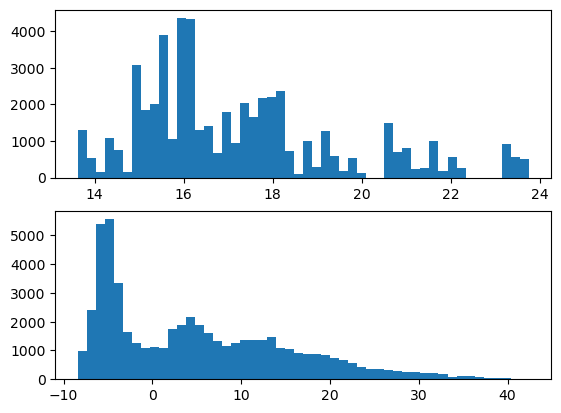

In [11]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [12]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:default:bert_multi_cased_L-12_H-7...,46,-8.397245,17.403856
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_16_train',b'layout:nlp:default:small_bert_bert_en_uncase...,61,-8.021685,17.053982
b'layout:nlp:default:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,10,-8.016908,18.141766
b'layout:nlp:random:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:random:bert_multi_cased_L-12_H-76...,50,-7.440794,17.404604
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16',b'layout:xla:default:resnet_v1_50_official_bat...,6,-7.417103,20.910105
b'layout:nlp:random:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,45,-7.229422,18.142046
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-768_A-12_batch_size_32_train',b'layout:nlp:default:small_bert_bert_en_uncase...,96,-7.220882,17.015160
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_16_train',b'layout:nlp:random:small_bert_bert_en_uncased...,15,-7.097349,17.054642
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train',b'layout:nlp:default:small_bert_bert_en_uncase...,9,-6.916347,15.192575


Text(0.5, 1.0, "b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'")

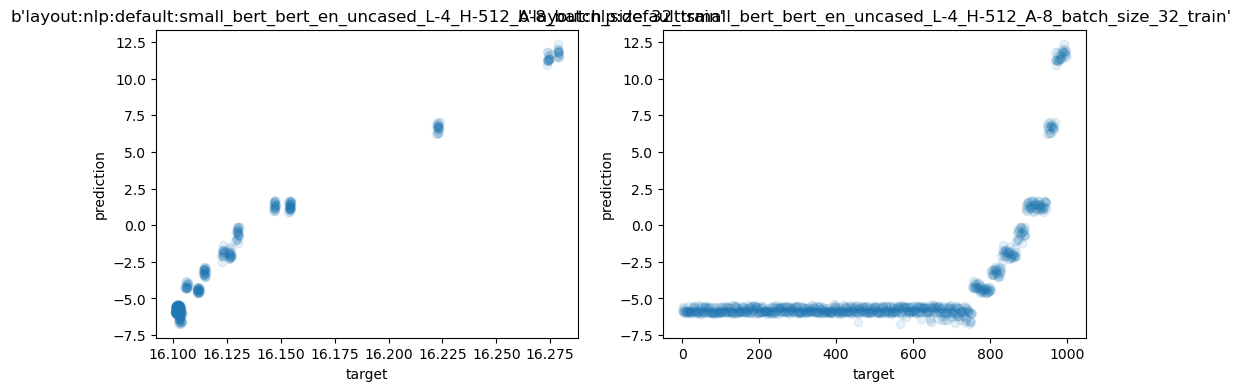

In [23]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

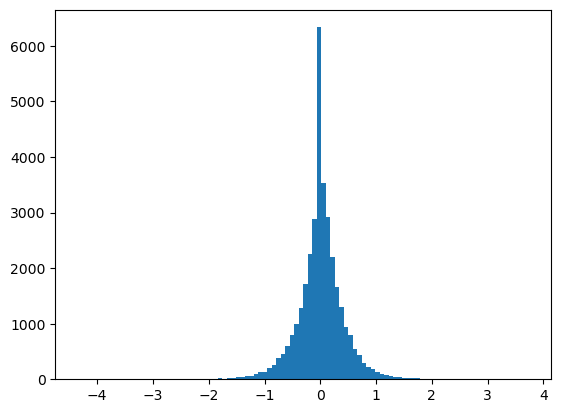

In [14]:
plt.hist(mlp.dense_layer_node_1.kernel.numpy().flatten(), bins=100);

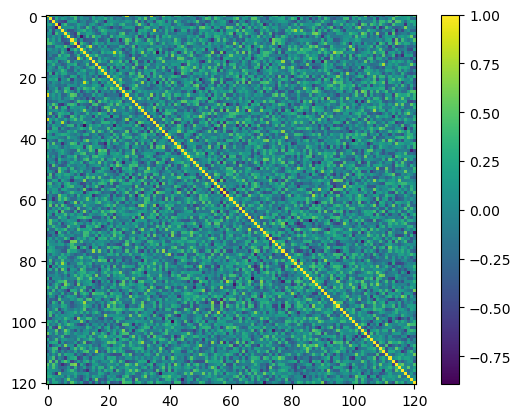

In [15]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
ind = np.unravel_index(np.argsort(dots.flatten())[-122], dots.shape)
ind

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [7]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

In [16]:
val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               16906;16851;27945;1994;33561;34138;40722;26433...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  53315;18482;53593;3341;2629;47238;58009;47265;...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              2423;22819;22875;16965;11262;2453;2442;7983;13...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      92318;45845;74443;12834;23970;37419;23971;7090...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     34635;34720;31792;34772;47564;19382;39702;4754...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      50879;34304;27993;50866;43033;404;7560;25607;4...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     988;2144;21383;27282;31270;1050;11396;38379;31...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [ ]:
val_df

In [ ]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

In [17]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

layout:xla:default 0.31952869019083047
layout:nlp:default 0.5102392263159744
layout:nlp:random 0.9235297456262017
layout:xla:random 0.6591447611780817


In [19]:
np.mean([0.3195286, 0.510239, 0.9235297, 0.659144])

0.6031103250000001

In [18]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:unet_3d.4x4.bf16'                                                  0.011819
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                          0.066881
b'layout:xla:random:unet_3d.4x4.bf16'                                                   0.133813
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'                              0.319005
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.326366
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'      0.401083
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'      0.417610
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train'      0.432561
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train'     0.433186
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_64_train'      0.453550
b'layout:xla:default:bert_p

In [ ]:
valid_nodes_list = []
for batch in dataset.valid_data:
    df = pd.DataFrame(
        np.stack([
            batch['layout_id'].numpy(), 
            batch['valid_nodes'].numpy()], axis=-1),
        columns=['ID', 'valid_nodes']
    ).drop_duplicates('ID')
    valid_nodes_list.append(df)
valid_nodes = pd.concat(valid_nodes_list).drop_duplicates('ID')
valid_nodes

In [ ]:
valid_nodes.set_index('ID', inplace=True)
valid_nodes['scores'] = val_scores
valid_nodes

In [ ]:
valid_nodes.reset_index(inplace=True)
valid_nodes

In [ ]:
valid_nodes['subset'] = valid_nodes['ID'].apply(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
valid_nodes

In [ ]:
plt.scatter(
    valid_nodes['scores'],
    valid_nodes['valid_nodes']
)

In [ ]:
subset = 'layout:nlp:default'
valid_nodes_subset = valid_nodes[valid_nodes['subset'] == subset]
print(valid_nodes_subset.sort_values('valid_nodes').iloc[-1])
plt.scatter(
    valid_nodes_subset['scores'],
    valid_nodes_subset['valid_nodes']
)

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [5]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:nlp:random:b2fdde3b729809075786487741...,0,9.712234
1,b'layout:nlp:default:23559853d9702baaaacbb0c83...,0,-3.379882
2,b'layout:nlp:random:b2fdde3b729809075786487741...,1,7.676553
3,b'layout:xla:random:937ee0eb0d5d6151b7b8252933...,0,17.390995
4,b'layout:xla:default:db59a991b7c607634f13570d5...,0,-3.652266
...,...,...,...
49997,b'layout:xla:random:db59a991b7c607634f13570d52...,997,2.869017
49998,b'layout:nlp:default:016ac66a44a906a695afd2228...,999,-3.907424
49999,b'layout:nlp:default:6c1101f6231f4d1722c3b9f6d...,999,3.925590
50000,b'layout:xla:random:db59a991b7c607634f13570d52...,998,3.659790


In [8]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    439;973;57;6;554;662;406;868;823;404;480;820;2...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    452;965;794;361;404;386;504;252;417;159;149;85...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    621;622;715;499;75;993;63;215;546;403;704;350;...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    73;194;134;10;286;733;34;191;498;974;32;196;29...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    587;997;327;892;967;7;224;887;313;643;936;638;...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    476;793;631;762;556;376;964;17;126;820;9;589;7...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    633;270;718;647;744;795;788;984;375;592;862;42...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    778;968;461;684;752;623;697;108;615;849;595;65...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    499;929;444;442;590;780;848;508;725;901;553;42...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [9]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_none_test_prediction_11_07_01_33.csv')